# Snippet search ML experiments & research

This document is related to experiments around code graph, where each line correspond to one node. 
An egde weight equal to number of simple identifiers that share between two lines. 

## Cut method 

Here one can find the small presentation with method scheme description. 

https://docs.google.com/presentation/d/1-jr0IqraXAI0WPEpb_dVdE_sTnOXQmuoJyeb8OgW4Zg/edit

Lets reproduse plot for this method

**TODO:** Add algo description

In [49]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ids2graph.line_ids2graph import get_cuts, get_ids, cuts2snippets
from bblfsh import BblfshClient

sns.set()
%matplotlib inline

In [2]:
filename = "./examples/example.py"
with open(filename, 'r') as f:
    codelines = ["{:2}  ".format(i) + x.strip("\n") for i, x in enumerate(f.readlines())]
ids = get_ids(filename)

lines_num = max([max(lines) for lines in ids.values()])
cut = get_cuts(ids, lines_num=lines_num)
res = cuts2snippets(cut)
snippets = cuts2snippets(cut)
print(snippets)

[[1, 4], [5, 9], [10, 25], [26, 34], [35, 49], [50, 54]]


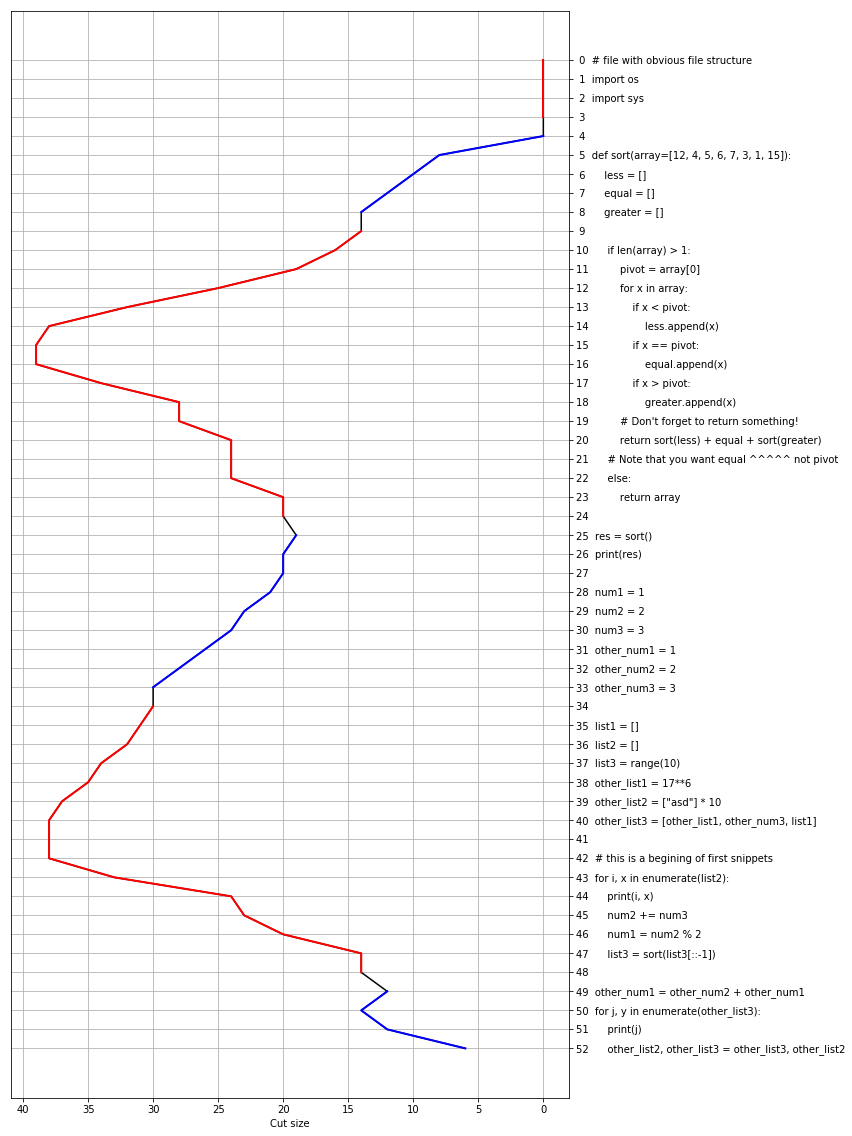

In [3]:
f = plt.figure(figsize=(10,20))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("right")
plt.yticks(range(len(cut)), codelines)
plt.xlabel("Cut size")
plt.grid()
#plt.hold("on")
col = ['r', 'b']
plt.plot(cut, range(len(cut)), 'k')
for indx, sn in enumerate(snippets):
    plt.plot(cut[sn[0]-1:sn[1]], range(sn[0]-1, min(sn[1], len(cut))), c=col[indx%len(col)], linewidth=2)
pass

It also rely on spases. Sometimes it leads to additional breaks (8-9, 33-34).
Easy thing to fix

## Lets build the graph!

`ids` is bidirectional graph if you think carefully 

In [4]:
ids

{'append': [15, 17, 19],
 'array': [6, 12, 13, 24, 11],
 'enumerate': [44, 51],
 'equal': [8, 17, 21],
 'greater': [9, 19, 21],
 'i': [45, 44],
 'j': [52, 54, 51],
 'len': [11],
 'less': [7, 15, 21],
 'list1': [36, 41],
 'list2': [37, 44],
 'list3': [38, 48, 48],
 'num1': [29, 47],
 'num2': [30, 46, 47],
 'num3': [31, 46],
 'os': [2],
 'other_list1': [39, 41],
 'other_list2': [40, 53, 53],
 'other_list3': [41, 53, 53, 51],
 'other_num1': [32, 50, 50],
 'other_num2': [33, 50, 54],
 'other_num3': [34, 41, 54],
 'pivot': [12, 14, 16, 18],
 'print': [27, 45, 52],
 'range': [38],
 'res': [26, 27],
 'sort': [6, 21, 21, 26, 48],
 'sys': [3],
 'x': [15, 14, 17, 16, 19, 18, 13, 45, 44],
 'y': [51]}

In [52]:
B = nx.Graph()
tokens = ids.keys()
tokens2id = {t: i for i, t in enumerate(tokens)}
B.add_nodes_from(tokens, bipartite=0)
B.add_nodes_from(range(lines_num), bipartite=1)
B.add_edges_from([(k, v) for k in ids for v in ids[k]])

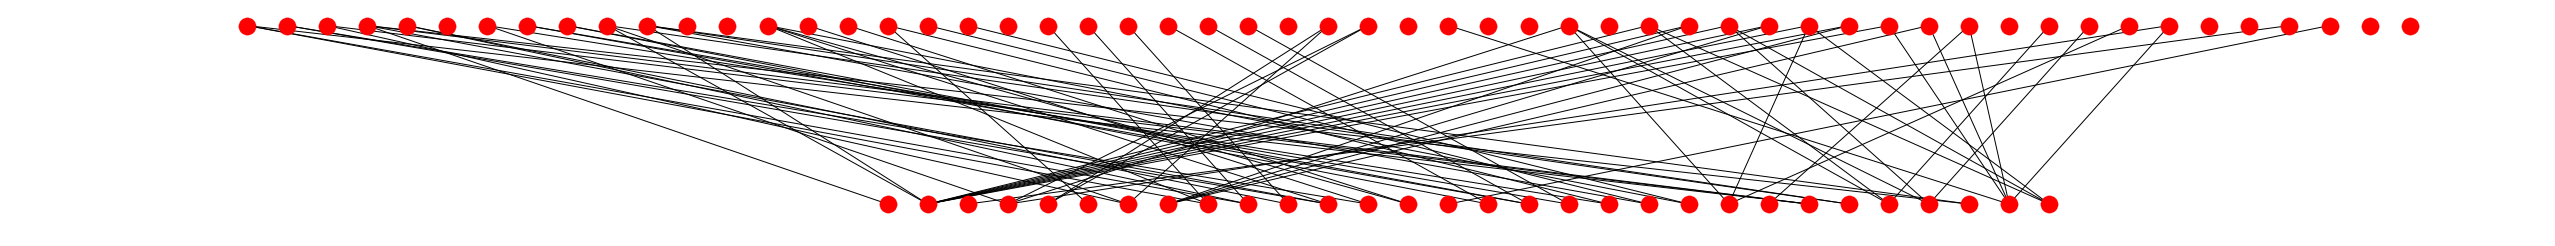

In [43]:
fig = plt.figure(figsize=(35,3))
pos = dict()
pos.update( (n, (-10*i, 1)) for i, n in enumerate(tokens) ) # put nodes from X at x=1
pos.update( (n, (90-10*i, 2)) for i, n in enumerate(range(lines_num + 1)) ) # put nodes from Y at x=2
nx.draw(B, pos=pos, label=True)
plt.show()

First row is code lines.
Second is identifiers.
It is not informative illustration. Let's plot next adjacency matrixes: token-line, token-token, line-line. 
2 and 3 we can build using token-line matrix (See code).

In [45]:
bi_adj = np.zeros((len(ids), lines_num))
for tokens in ids:
    for line in ids[tokens]:
        bi_adj[tokens2id[tokens]][line-1] += 1
        
id2id = bi_adj.dot(bi_adj.T) # that is  how we build token-token matrix
line2line = bi_adj.T.dot(bi_adj) # that is  how we build line-line matrix

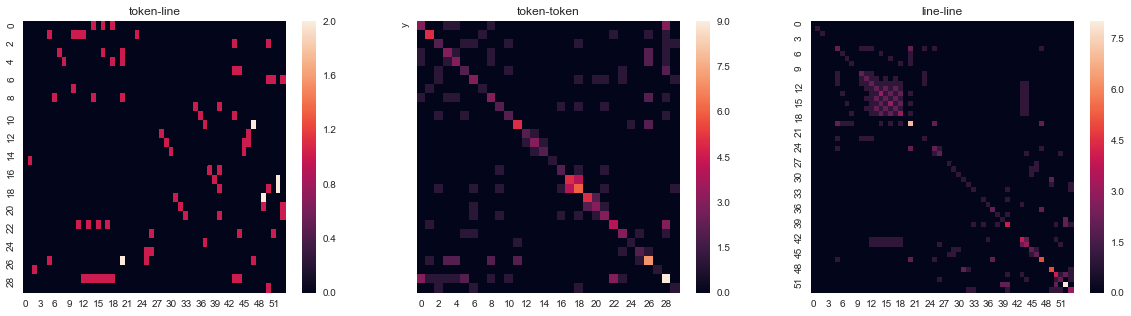

In [48]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.heatmap(bi_adj)
plt.title("token-line")
plt.subplot(1,3,2)
sns.heatmap(id2id, yticklabels=tokens)
plt.title("token-token")
plt.subplot(1,3,3)
sns.heatmap(line2line)
plt.title("line-line");

Ok, one can see some structure, but it is fuzzy.

Let's try similar approach whitch @egorbu described here: https://github.com/src-d/ml/blob/master/ast2vec/repo2/coocc.md and compare results.

## ast2vec style

Some code. You can scroll till pictures.

In [10]:
import importlib
from bblfsh.sdkversion import VERSION

Node = importlib.import_module(
        "bblfsh.gopkg.in.bblfsh.sdk.%s.uast.generated_pb2" % VERSION).Node

class Roles:
    pass

_ROLE = importlib.import_module("bblfsh.gopkg.in.bblfsh.sdk.%s.uast.generated_pb2" % VERSION)._ROLE
for desc in _ROLE.values:
    setattr(Roles, desc.name, desc.index)
del _ROLE

In [11]:
import itertools

from bblfsh.sdkversion import VERSION

def _flatten_children(root, last_pos):
    ids = []
    stack = list(root.children)
    for node in stack:
        if node.start_position is not None:
            last_pos = node.start_position.line
        if Roles.IDENTIFIER in node.roles and Roles.QUALIFIED not in node.roles:
            ids.append((node, last_pos))
        else:
            stack.extend(node.children)
    return ids

def _traverse_uast(uast):
    """
    Traverses UAST.
    """
    if isinstance(uast, bytearray):
        uast = importlib.import_module(
            "bblfsh.gopkg.in.bblfsh.sdk.%s.uast.generated_pb2" % VERSION).Node.FromString(uast)
    
    stack = [(uast, 0)]
    new_stack = []
    
    while stack:
        for node, node_pos in stack:
            children = _flatten_children(node, node_pos)
            tokens = []
            for ch, pos in children:
                tokens.append((ch.token, pos))
            if (node.token.strip() is not None and node.token.strip() != "" and
                    Roles.IDENTIFIER in node.roles and Roles.QUALIFIED not in node.roles):
                tokens.append((node.token, node.start_position.line))
            for pair in itertools.permutations(tokens, 2):
                yield pair
            
            new_stack.extend(children)
            
        stack = new_stack
        new_stack = []

In [12]:
filepath = "./examples/example.py"
client = BblfshClient("0.0.0.0:9432")
uast = client.parse(filepath).uast
    
id2id_v = np.zeros((len(tokens2id),len(tokens2id)))
line2line_v = np.zeros((lines_num, lines_num))    
for x, y in _traverse_uast(uast):
    id2id_v[tokens2id[x[0]]][tokens2id[y[0]]] += 1
    line2line_v[x[1]-1][y[1]-1] += 1

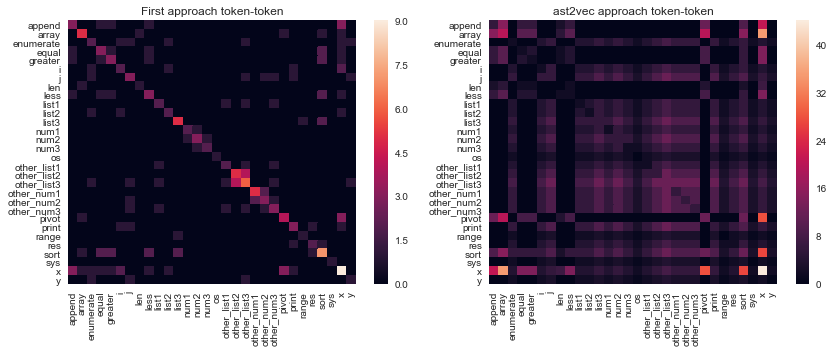

In [83]:
plt.figure(figsize=(12,5))
vmin=0
vmax= None# max(id2id.max(), id2id_v.max())
plt.subplot(1,2,1)
sns.heatmap(id2id, xticklabels=tokens, yticklabels=tokens, vmin=vmin, vmax=vmax)
plt.title("First approach token-token")
plt.subplot(1,2,2)
sns.heatmap(id2id_v, xticklabels=tokens, yticklabels=tokens, vmin=vmin, vmax=vmax)
plt.title("ast2vec approach token-token")
plt.tight_layout()

Please note, that color axis are not the same.

What we can see.
1. Don't see any structure on both plots. First are too sparce, Second too evenly dense. May be just bad example.
2. ast2vec approach has exponential nature of weights as expected.

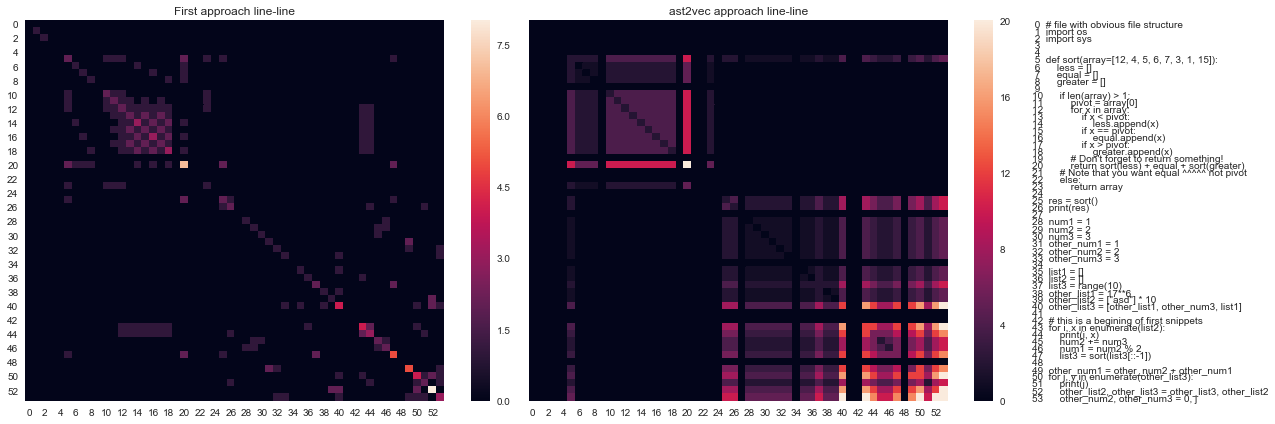

In [84]:
vmin = 0
vmax = None  # max(line2line.max(), line2line_v.max())

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.heatmap(line2line, vmin=vmin, vmax=vmax)
plt.title("First approach line-line")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(rotation=0)

ax = plt.subplot(1,2,2)
sns.heatmap(line2line_v, yticklabels= [" " * 28 + line for line in codelines], vmin=vmin, vmax=vmax)
plt.title("ast2vec approach line-line")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(rotation=0)
plt.tight_layout()

Please note, that color axis are the not same.

What we can see.
1. See structure on both plots. But first is not so good
2. If we cross out blank lines it is really awesome plot. Look:

In [80]:
noblanks = np.where(line2line_v.sum(axis=1) != 0)[0]
print("Not 'blank' lines are: {}".format(noblanks))

Not 'blank' lines are: [ 5  6  7  8 10 11 12 13 14 15 16 17 18 20 23 25 26 28 29 30 31 32 33 35 36
 37 38 39 40 43 44 45 46 47 49 50 51 52 53]


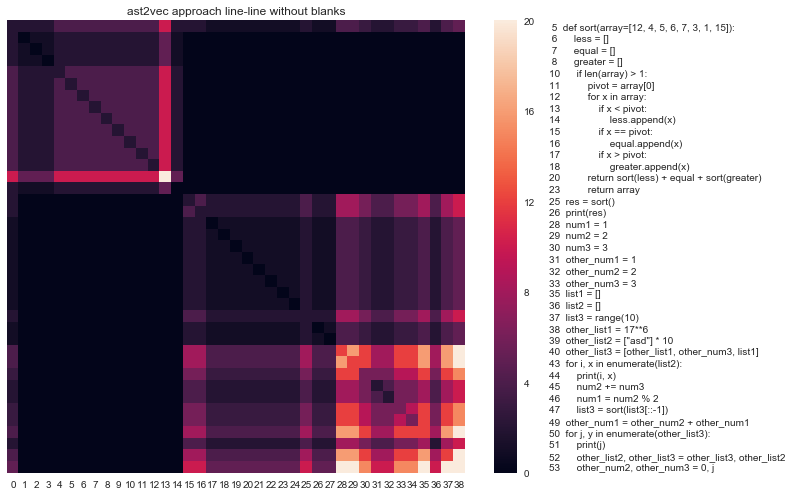

In [81]:
plt.figure(figsize=(11,7))
ax = plt.subplot(1,1,1)
labels = [" " * 28 + line for i, line in enumerate(codelines) if i in noblanks]
sns.heatmap(line2line_v[:, noblanks][noblanks, :], 
            yticklabels= labels, vmin=vmin, vmax=vmax)
plt.title("ast2vec approach line-line without blanks")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(rotation=0)
plt.tight_layout()

Seems like good way to visualize code structure.

We can see 3 snippets here. The third one is inside the second.
So we also can understand using only code tree structure.

But it can not find 5 line (49-53) snippet in the end of file.

Let's try to combine matrises:

Matrix combination:

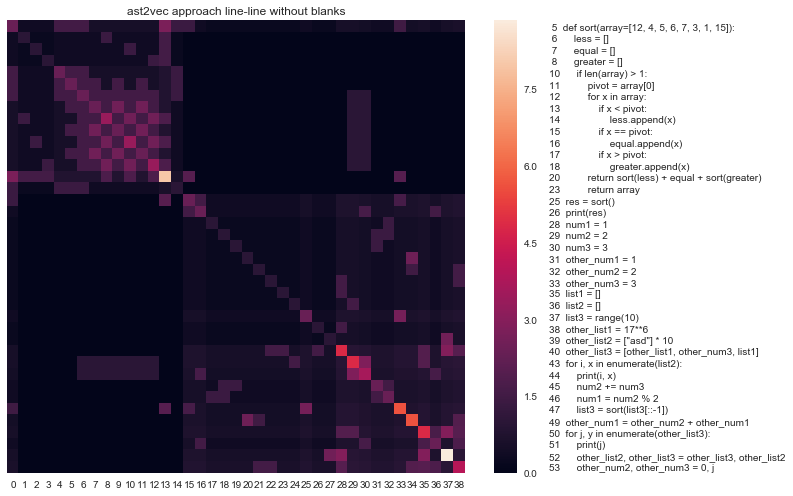

In [95]:
plt.figure(figsize=(11,7))
ax = plt.subplot(1,1,1)
labels = [" " * 28 + line for i, line in enumerate(codelines) if i in noblanks]
mtx = line2line + np.log(1 + line2line_v) / np.log(1 + line2line_v).max()
mtx = mtx[:, noblanks][noblanks, :] 
sns.heatmap(mtx, yticklabels=labels, vmin=vmin, vmax=vmax)
plt.title("ast2vec approach line-line without blanks")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(rotation=0)
plt.tight_layout()

In [96]:
import igraph

In [109]:
G = igraph.Graph.Adjacency((mtx > 0).tolist())
G.es['weight'] = mtx[mtx.nonzero()]
G.to_undirected()

In [113]:
list(G.community_walktrap().as_clustering())

[[0,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]